In [ ]:
!pip install torch-mimicry;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import torch
from torch import nn
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Categorical
import pyro
from pyro.infer import MCMC, HMC as pyro_hmc, NUTS as pyro_nuts
from matplotlib import pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple, Iterable, Callable, Union
from tqdm import tqdm, trange
from scipy.stats import gaussian_kde
from scipy.special import logsumexp

from torch_mimicry.nets import sngan

sns.set_theme('talk', style="white")


In [ ]:
N_CHAINS = 10
N_SAMPLES = 1000
BURN_IN = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def ema(series: Iterable, n: int) -> List:
    """
    returns an n period exponential moving average for
    the time series
    """
    series = np.array(series)
    ema = []
    j = 1

    #get n sma first and calculate the next n period ema
    sma = sum(series[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    #EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(( (series[n] - sma) * multiplier) + sma)

    #now calculate the rest of the values
    for i in series[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema

In [ ]:
def HMC(start,
        target, 
        n_samples: int,
        burn_in: int, 
        *, 
        step_size: float,
        num_leapfrog_steps: float = 1,
        verbose: bool = False) -> torch.FloatTensor:
    """
    Hamiltonian Monte Carlo

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """

    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_hmc(
        potential_fn=energy, step_size=step_size, num_steps=num_leapfrog_steps, full_mass=False
        )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape).detach().cpu()

    return samples_true
    

In [ ]:
def MALA(start: torch.FloatTensor, 
        target, 
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float, 
        verbose: bool=False) -> Tuple[torch.FloatTensor, List]:
    """
    Metropolis-Adjusted Langevin Algorithm with Normal proposal

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        step_size - step size for drift term
        verbose - whether show iterations' bar

    Returns:
        sequence of slices per each iteration, acceptance rates per each iteration
    """
    std_normal = MNormal(torch.zeros(start.shape[-1], device=start.device), torch.eye(start.shape[-1], device=start.device))
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    grad_x = torch.autograd.grad(logp_x.sum(), x)[0]

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        noise =  torch.randn_like(x)
        y = x + step_size * grad_x + noise * (2 * step_size) ** .5

        logp_y = target.log_prob(y)
        grad_y = torch.autograd.grad(logp_y.sum(), y)[0]

        log_qyx = std_normal.log_prob(noise)
        log_qxy = std_normal.log_prob((x - y - step_size * grad_y) / (2 * step_size) ** .5)
        
        accept_prob = torch.clamp((logp_y + log_qxy - logp_x - log_qyx).exp(), max=1)
        mask = torch.rand_like(accept_prob) < accept_prob

        with torch.no_grad():
            x[mask, :] = y[mask, :]
            logp_x[mask] = logp_y[mask]
            grad_x[mask] = grad_y[mask]

        acceptance_rate.append(mask.float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.cpu().clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate


In [ ]:
def ISIR(start: torch.FloatTensor, 
        target,
        proposal, 
        n_samples: int,
        burn_in: int, 
        *, 
        n_particles: int, 
        verbose: bool=False) -> Tuple[List[torch.FloatTensor], List]:
    """
    Iterated Sampling Importance Resampling

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        n_particles - number of particles including one from previous step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        logqs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        logps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = logps - logqs
        indices = Categorical(logits=log_weights).sample()
        
        x = particles[np.arange(x.shape[0]), indices].detach()
        logp_x = logps[np.arange(x.shape[0]), indices].detach()
        logq_x = logqs[np.arange(x.shape[0]), indices].detach()

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.cpu().clone())
    chains = torch.stack(chains, 0)        
    return chains, acceptance_rate
    

In [ ]:
def Ex2MCMC(start: torch.FloatTensor, 
        target,
        proposal,
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float,
        n_particles: int, 
        n_mala_steps: int = 1,
        verbose: bool=False) -> Tuple[List[torch.FloatTensor], List]:
    """
    Ex2MCMC

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        n_particles - number of particles including one from previous step
        n_mala_steps - number of MALA steps after each SIR step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        log_qs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        log_ps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = log_ps - log_qs
        indices = Categorical(logits=log_weights).sample()
        x = particles[np.arange(x.shape[0]), indices]

        if n_mala_steps > 0:
            xs, acc = MALA(x, target, n_mala_steps, 0, step_size=step_size)
            x = xs[-1].to(x.device)
            logp_x = target.log_prob(x).detach()
            logq_x = proposal.log_prob(x).detach()
        else:
            logp_x = log_ps[np.arange(x.shape[0]), indices].detach()
            logq_x = log_qs[np.arange(x.shape[0]), indices].detach()

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.cpu().clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate
    

In [ ]:
class TargetGAN(object):
    def __init__(
            self, 
            gen: nn.Module, 
            dis: nn.Module, 
            device: Union[str, int, torch.device], 
            batch_size: int = 128
            ):
        self.gen = gen
        self.dim = gen.latent_dim
        self.dis = dis
        self.device = device
        self.batch_size = batch_size

    def batch_log_prob(self, z: torch.FloatTensor):
        return  self.gen.prior.log_prob(z) + 3 * self.dis(self.gen(z)).squeeze()

    def log_prob(self, z: torch.FloatTensor, batch_size: Optional[int] = None):
        z_flat = z.reshape(-1, self.dim)
        batch_size = batch_size or self.batch_size
        return torch.cat(list(map(self.batch_log_prob, z_flat.split(batch_size, 0))), 0).reshape(z.shape[:-1])
    

In [ ]:
latent_dim = 128
batch_size = 128

gen_cifar10 = sngan.SNGANGenerator32(nz=latent_dim).to(device)
gen_cifar10.latent_dim = latent_dim
dis_cifar10 =  sngan.SNGANDiscriminator32().to(device)

prior_cifar10 = MNormal(
    torch.zeros(latent_dim).to(device), torch.eye(latent_dim).to(device)
    )

gen_cifar10.prior = prior_cifar10
start_cifar10 = prior_cifar10.sample((N_CHAINS,))

In [ ]:
! if [ ! -f "cifar10_sngan_G.pth" ]; then gdown --id 1qWp3n0aOQ9szJdDZZtRhHT9wlCvro4MF; fi
! if [ ! -f "cifar10_sngan_D.pth" ]; then gdown --id 1dh6U43zQFR9QeEnzCKeHrlajVBrqZzop; fi

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1qWp3n0aOQ9szJdDZZtRhHT9wlCvro4MF
To: /content/cifar10_sngan_G.pth
100% 51.4M/51.4M [00:00<00:00, 235MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1dh6U43zQFR9QeEnzCKeHrlajVBrqZzop
To: /content/cifar10_sngan_D.pth
100% 12.7M/12.7M [00:00<00:00, 260MB/s]


In [ ]:
gen_cifar10.load_state_dict(torch.load('cifar10_sngan_G.pth')['model_state_dict'])
dis_cifar10.load_state_dict(torch.load('cifar10_sngan_D.pth')['model_state_dict'])
gen_cifar10.eval()
dis_cifar10.eval();

gan_target = TargetGAN(gen_cifar10, dis_cifar10, device=device, batch_size=batch_size)

RuntimeError: ignored

In [ ]:
a = 2
N_pts = 30

xs = np.linspace(-2*a, 2*a, N_pts)
ys = np.linspace(-2*a, 2*a, N_pts)
X, Y = np.meshgrid(xs, ys)
grid = np.stack([X, Y], -1)
grid = torch.FloatTensor(grid).to(device)

proj_coords = []
log_dens_projs = []

for j in tqdm(range(9)):
    while True:
        pair = tuple(np.random.choice(latent_dim, 2, replace=False))
        if pair not in proj_coords:
            proj_coords.append(pair)
            break
    i1 = pair[0]
    i2 = pair[1]
    c1 = torch.zeros(latent_dim).to(device)
    c1[i1] = 1
    c2 = torch.zeros(latent_dim).to(device)
    c2[i2] = 1
    z = grid @ torch.stack((c1, c2))
    
    log_prob = gan_target.log_prob(z).detach().cpu().numpy() 
    log_dens_projs.append(log_prob)

100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


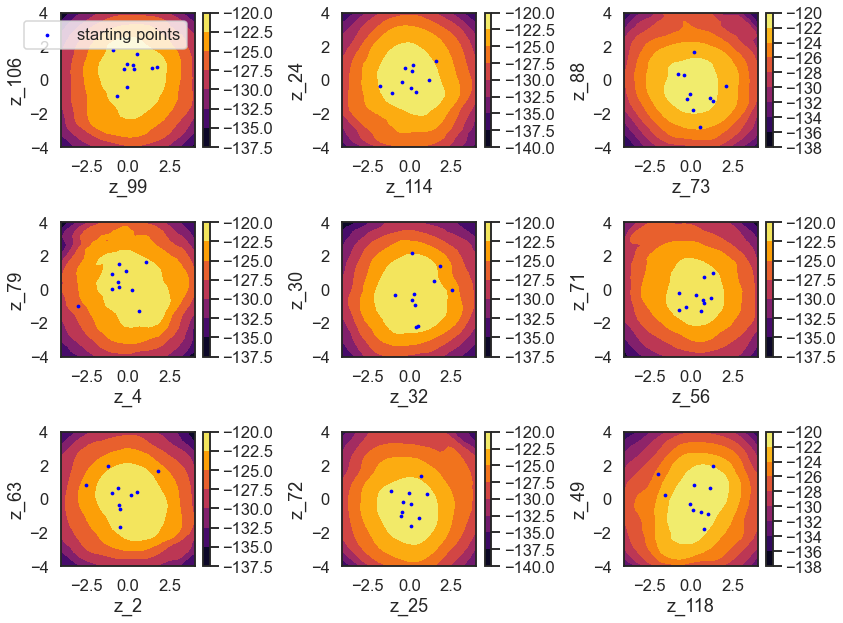

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))

for idx, ax in enumerate(axs.flat):
    log_prob = log_dens_projs[idx]
    proj_coord = proj_coords[idx]

    cp = ax.contourf(X, Y, log_prob, cmap='inferno')
    fig.colorbar(cp, ax=ax)

    ax.scatter(*start_cifar10[:, proj_coord].T.cpu(), s=5, color='blue', label='starting points')
    if idx == 0:
        ax.legend()
    
    ax.set_xlabel(fr'z_{proj_coord[0]}')
    ax.set_ylabel(fr'z_{proj_coord[1]}')
    
fig.tight_layout()
plt.show()

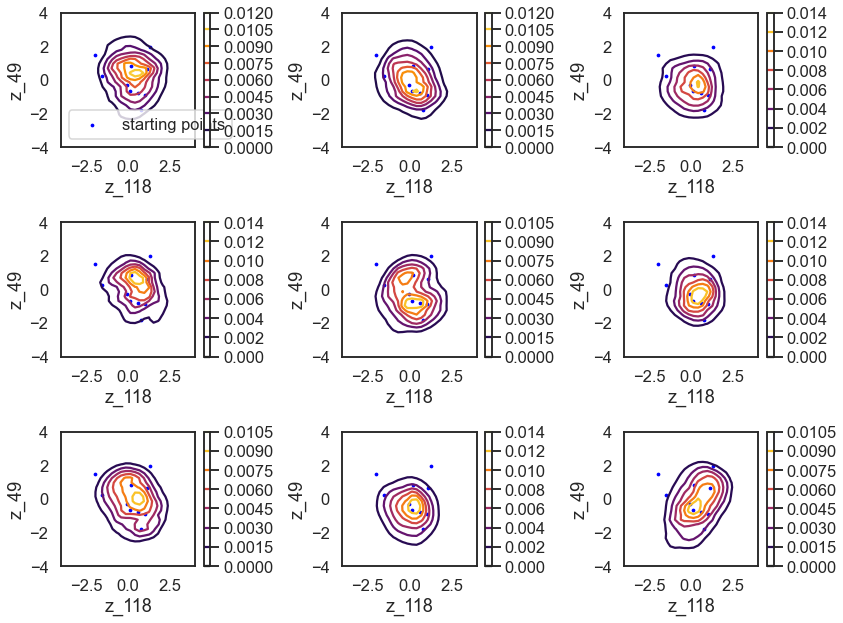

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))

for idx, ax in enumerate(axs.flat):
    log_prob = log_dens_projs[idx]

    cp = ax.contour(X, Y, np.exp(log_prob - logsumexp(log_prob)), cmap='inferno')
    fig.colorbar(cp, ax=ax)

    ax.scatter(*start_cifar10[:, proj_coord].T.cpu(), s=5, color='blue', label='starting points')
    if idx == 0:
        ax.legend()
    
    ax.set_xlabel(fr'z_{proj_coord[0]}')
    ax.set_ylabel(fr'z_{proj_coord[1]}')
    
fig.tight_layout()
plt.show()

In [ ]:
proposal_scale = 1.0
n_particles = 10
proposal = MNormal(torch.zeros(gan_target.dim).to(device), torch.eye(gan_target.dim).to(device) * proposal_scale**2)

isir_chains, acceptance_rates = ISIR(start_cifar10, gan_target, proposal, N_SAMPLES, BURN_IN, n_particles=n_particles, verbose=True)

100%|██████████| 1100/1100 [01:21<00:00, 13.44it/s]


Text(0.5, 0, 'Iteration')

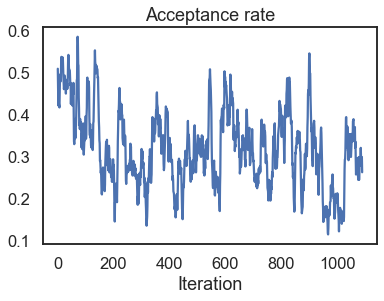

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [ ]:
step_size = 0.01
mala_chains, acceptance_rates = MALA(start_cifar10, gan_target, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:21<00:00, 51.57it/s]


Text(0.5, 0, 'Iteration')

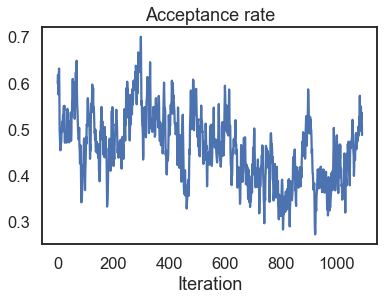

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [ ]:
step_size = 0.01
proposal_scale = 1.0
n_particles = 10
n_mala_steps = 1
proposal = MNormal(
    torch.zeros(gan_target.dim).to(device), torch.eye(gan_target.dim).to(device) * proposal_scale**2)

ex2_chains, acceptance_rates = Ex2MCMC(start_cifar10, gan_target, proposal, N_SAMPLES, BURN_IN, 
    step_size=step_size, n_particles=n_particles, n_mala_steps=n_mala_steps, verbose=True)

100%|██████████| 1100/1100 [02:15<00:00,  8.13it/s]


Text(0.5, 0, 'Iteration')

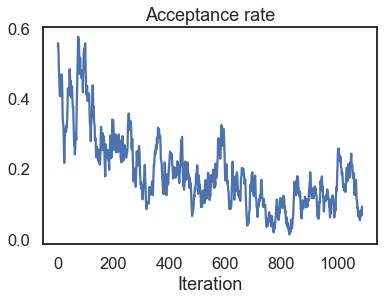

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [ ]:
step_size = 0.01
num_leapfrog_steps = 3

hmc_chains = HMC(start_cifar10.to(device), gan_target, N_SAMPLES, BURN_IN, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps, verbose=True)

Sample: 100%|██████████| 1100/1100 [00:21, 50.68it/s, step size=2.27e-01, acc. prob=0.884]


In [ ]:
chain_id = 0

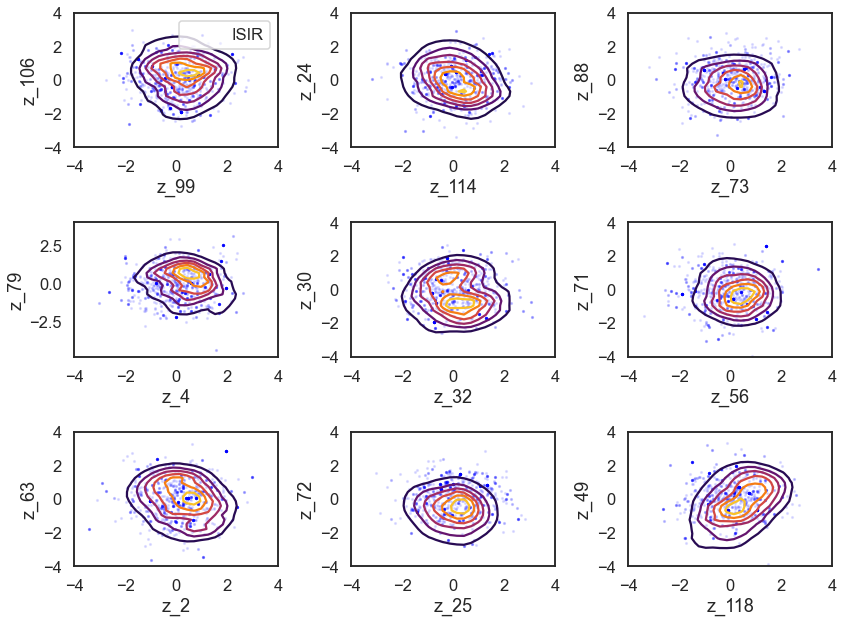

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))

for idx, ax in enumerate(axs.flat):
    proj_coord = proj_coords[idx]

    dens = np.exp(log_dens_projs[idx] - logsumexp(log_dens_projs[idx]))

    ax.contour(X, Y, dens, cmap='inferno')
    #fig.colorbar(cp, ax=ax)

    result = isir_chains[:, chain_id, proj_coord].reshape(-1, 2)
    ax.scatter(*result.T, color='blue', s=3, alpha=0.1, label='ISIR')
    if idx == 0:
        ax.legend()
    
    ax.set_xlabel(fr'z_{proj_coord[0]}')
    ax.set_ylabel(fr'z_{proj_coord[1]}')
    
fig.tight_layout()
plt.show()

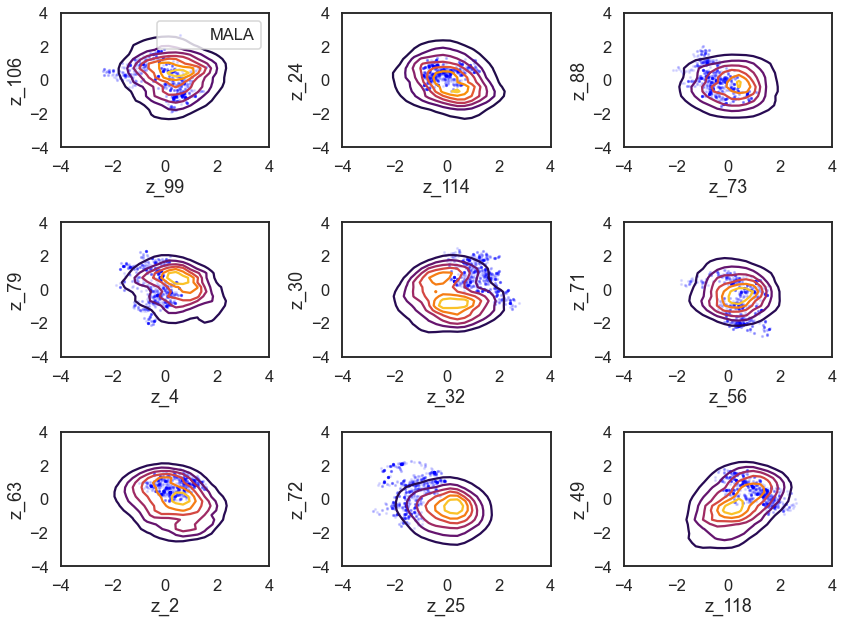

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))

for idx, ax in enumerate(axs.flat):
    proj_coord = proj_coords[idx]

    dens = np.exp(log_dens_projs[idx] - logsumexp(log_dens_projs[idx]))

    ax.contour(X, Y, dens, cmap='inferno')
    #fig.colorbar(cp, ax=ax)

    result = mala_chains[:, chain_id, proj_coord].reshape(-1, 2)
    ax.scatter(*result.T, color='blue', s=3, alpha=0.1, label='MALA')
    if idx == 0:
        ax.legend()
    
    ax.set_xlabel(fr'z_{proj_coord[0]}')
    ax.set_ylabel(fr'z_{proj_coord[1]}')
    
fig.tight_layout()
plt.show()

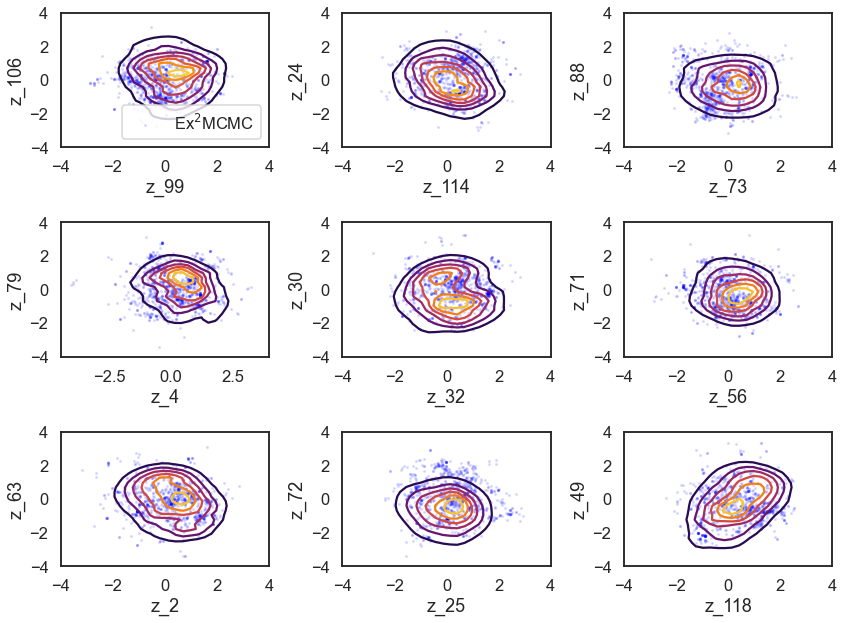

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))

for idx, ax in enumerate(axs.flat):
    proj_coord = proj_coords[idx]

    dens = np.exp(log_dens_projs[idx] - logsumexp(log_dens_projs[idx]))

    ax.contour(X, Y, dens, cmap='inferno')
    #fig.colorbar(cp, ax=ax)

    result = ex2_chains[:, chain_id, proj_coord].reshape(-1, 2)
    ax.scatter(*result.T, color='blue', s=3, alpha=0.1, label=r'Ex$^2$MCMC')
    if idx == 0:
        ax.legend()
    
    ax.set_xlabel(fr'z_{proj_coord[0]}')
    ax.set_ylabel(fr'z_{proj_coord[1]}')
    
fig.tight_layout()
plt.show()

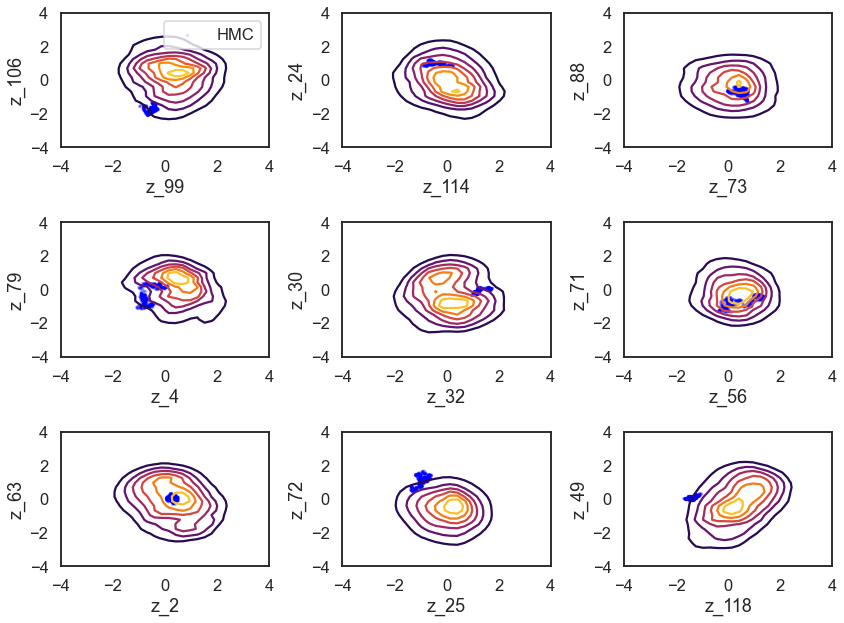

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))

for idx, ax in enumerate(axs.flat):
    proj_coord = proj_coords[idx]

    dens = np.exp(log_dens_projs[idx] - logsumexp(log_dens_projs[idx]))

    ax.contour(X, Y, dens, cmap='inferno')
    #fig.colorbar(cp, ax=ax)

    result = hmc_chains[:, chain_id, proj_coord].reshape(-1, 2)
    ax.scatter(*result.T, color='blue', s=3, alpha=0.1, label=r'HMC')
    if idx == 0:
        ax.legend()
    
    ax.set_xlabel(fr'z_{proj_coord[0]}')
    ax.set_ylabel(fr'z_{proj_coord[1]}')
    
fig.tight_layout()
plt.show()

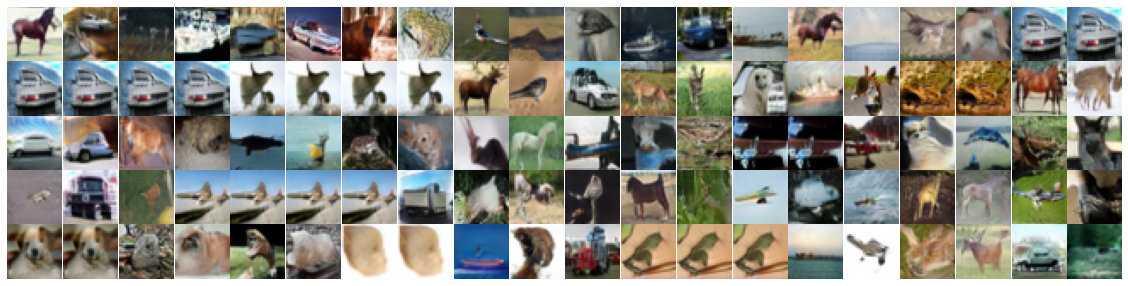

In [ ]:
show_every_n = 5
show_first_n = 500
zs = isir_chains[0 : show_first_n * show_every_n : show_every_n, chain_id, :]

fig = plt.figure(figsize=(20,5))
axs = [fig.add_subplot(5, 20, i+1) for i in range(100)]

for idx, ax in enumerate(axs):
    img = (1 + gen_cifar10(zs[[idx]].to(device))[0].detach().permute(1, 2, 0)) / 2
    ax.imshow(img.detach().cpu().numpy(), cmap='gray')
    ax.axis('off')
fig.subplots_adjust(wspace=0, hspace=0)

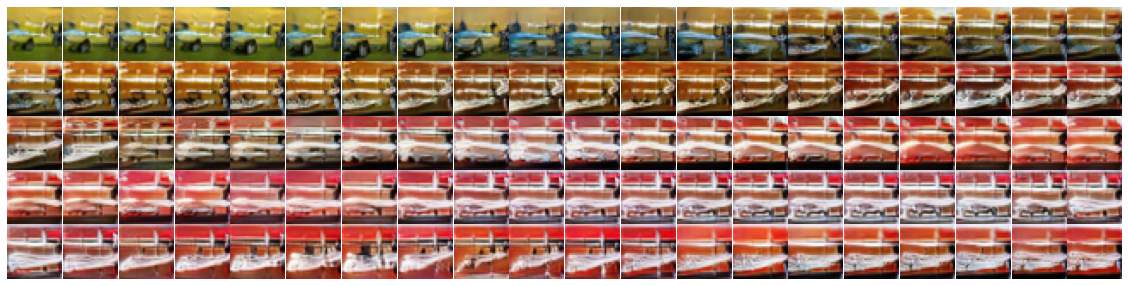

In [ ]:
show_every_n = 5
show_first_n = 500
zs = mala_chains[0 : show_first_n * show_every_n : show_every_n, chain_id, :]

fig = plt.figure(figsize=(20,5))
axs = [fig.add_subplot(5, 20, i+1) for i in range(100)]

for idx, ax in enumerate(axs):
    img = (1 + gen_cifar10(zs[[idx]].to(device))[0].detach().permute(1, 2, 0)) / 2
    ax.imshow(img.detach().cpu().numpy(), cmap='gray')
    ax.axis('off')
fig.subplots_adjust(wspace=0, hspace=0)

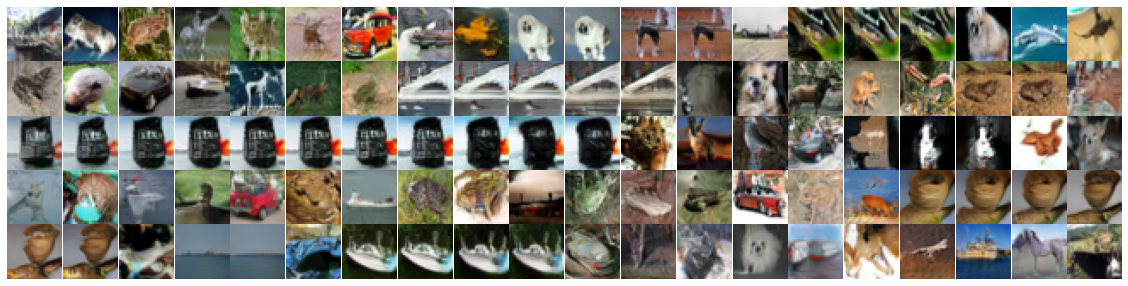

In [ ]:
show_every_n = 5
show_first_n = 500
zs = ex2_chains[0 : show_first_n * show_every_n : show_every_n, chain_id, :]

fig = plt.figure(figsize=(20,5))
axs = [fig.add_subplot(5, 20, i+1) for i in range(100)]

for idx, ax in enumerate(axs):
    img = (1 + gen_cifar10(zs[[idx]].to(device))[0].detach().permute(1, 2, 0)) / 2
    ax.imshow(img.detach().cpu().numpy(), cmap='gray')
    ax.axis('off')
fig.subplots_adjust(wspace=0, hspace=0)